<a href="https://colab.research.google.com/github/thiagomelostuckert/datathon-fakenews/blob/main/2_Modelos_de_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Construção de dois modelos de aprendizado de máquinas que automatizem a detecção de notícias falsas

A etapa seguinte, a ser tocada pelo cientista de dados, envolve o treinamento do modelo. Já tendo em mãos a base de dados de treino preparada pelo analista de dados, o cientista de dados deverá desenvolver pelo menos dois modelos (note que a escolha do modelo pode implicar mudança no tratamento prévio da base de dados), considerando diferentes cenários de inferência.
O cientista de dados deverá considerar dois cenários para inferência para definição dos modelos: batch (quando há uma série de notícias a serem avaliadas simultaneamente) e streaming (uma notícia por vez, em tempo real). Deverá haver justificativa para a escolha de cada modelo para as diferentes finalidades possíveis nas atividades de inteligência, e também devem constar as estatísticas de treino (report de classificação, matriz de confusão, etc.)
Finalmente, o cientista de dados deverá salvar os parâmetros do modelo treinado considerando inferência em streaming no formato ‘pickle’, que será utilizado na próxima etapa.
Recomenda-se utilizar as bibliotecas mais consolidadas para machine learning, como sklearn, tensorflow e pytorch. Não é necessário desenvolver soluções que envolvam poder computacional que exceda a capacidade do Google Colab gratuito.
A avaliação se dará com a performance dos modelos (não disponibilizamos parte da base de dados para verificar o poder de generalização dos modelos); eficiência de código; escolha de cada modelo para qual finalidade.

Importação das bibliotecas

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# Modelos das abordagens clássicas
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Bibliotecas utilizadas para calcular as métricas dos modelos
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score

sns.set()

Leitura dos arquivos de entrada para os modelos

In [101]:
#Leitura dos textos
url_textos = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_data.csv"
df_textos = pd.read_csv(url_textos, on_bad_lines = 'warn')

In [102]:
#Leitura das classificações
url_classificacoes = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_labels.csv"
df_classificacoes = pd.read_csv(url_classificacoes, on_bad_lines = 'warn')

In [103]:
#Junta os dois datasets em um único dataframe
df = pd.merge(df_textos, df_classificacoes, left_index=True, right_index=True)
df.columns

Index(['preprocessed_news', 'label'], dtype='object')

In [108]:
# Questionar aos organizadores do Datathon se podemos utilizar o arquivo
# pré-processado do repositório do professor como conjunto de dados para testes dos modelos
#Leitura dos textos utilizados no teste
#url_test_data = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/pre-processed.csv"
#df_test_data = pd.read_csv(url_test_data, on_bad_lines = 'warn')
#df_test_data = df_test_data.drop("index",axis=1)

In [122]:
# Treina o modelo e apresenta suas métricas
def fit_and_evaluate_model(model,df):
  # Divide o dataset em treinamento (67%) e teste (33%)
  X_train, X_test, y_train, y_test = train_test_split(
  df.preprocessed_news, df.label, test_size=0.33, random_state=42)
  # Treina o modelo com os textos e suas classificações
  model.fit(X_train, y_train)
  #Faz a predição dos textos da base de testes com o modelo Naive Bayes
  predicted_labels = model.predict(X_test)
  # Análise da eficiência do modelo
  # Matriz de confusão
  conf_mat = confusion_matrix(y_test, predicted_labels,labels=["fake","true"],  normalize="true")
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
  disp.plot()
  plt.show()
  # Imprime outras métricas
  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  print("Acurácia: {}".format(accuracy_score(y_test, predicted_labels)))
  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
  print("F1-Score: {}".format(f1_score(y_test, predicted_labels, average='macro')))
  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
  print("Precisão média: {}".format(precision_score(y_test, predicted_labels, average='macro')))


Significado das células da matriz de confusão

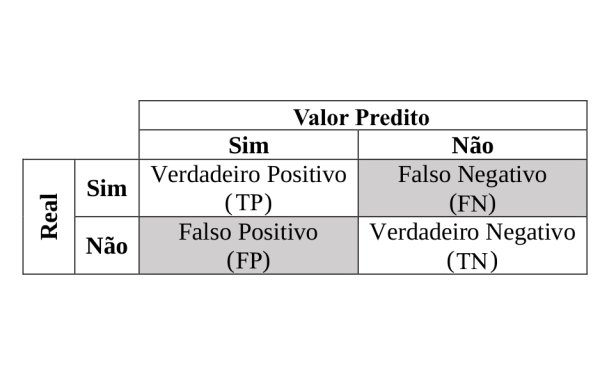

### Abordagens clássicas

Modelo clássico usando Naive Bayes

Referências:
https://www.turing.com/kb/document-classification-using-naive-bayes

https://towardsdatascience.com/implementing-a-naive-bayes-classifier-for-text-categorization-in-five-steps-f9192cdd54c3

Iremos utilizar o TfidfVectorizer para construir uma matriz de frequências invertidas, conhecido em inglês por term Frequency - Inverse Document Frequency (TF-IDF)
 https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency

MultinomialNB é um classificador Naive Bayes
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html



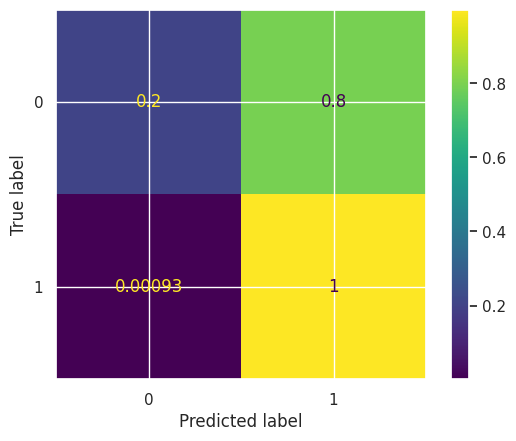

Acurácia: 0.6021505376344086
F1-Score: 0.5275438438484426
Precisão média: 0.7762577573546828


In [123]:
# Construção de uma modelo clássico usando Naive Bayes
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
fit_and_evaluate_model(model,df)

Regressão logística

Referências: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


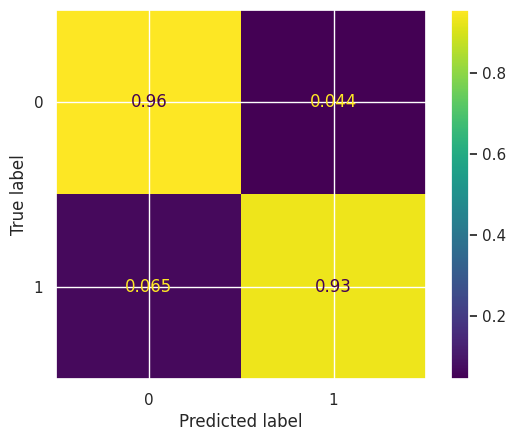

Acurácia: 0.9453015427769986
F1-Score: 0.945295755892505
Precisão média: 0.9455036367643818


In [124]:
# Construção de uma modelo clássico usando Naive Bayes
model = make_pipeline(TfidfVectorizer(), LogisticRegression())
fit_and_evaluate_model(model,df)

Modelo Batch (quando há uma série de notícias a serem avaliadas simultaneamente)

Model streaming (uma notícia por vez, em tempo real)

Salvar os parâmetros do modelo treinado considerando inferência em streaming no formato ‘pickle’